## B cells versus T cells
The data used in this notebook is lymphocyte data for subject 1's B cells and T cells. We use this data to show the proteome variation between the cell types. Here, we note presence/absense changes and quantify fold changes using a T test.


In [1]:
import longitudinalCLL
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import log10
import numpy as np
import pandas as pd
from gprofiler import GProfiler
import numpy as np
from statistics import mean

### Access data
First, we import our data package. This brings the functions defined there into scope so we can use them in this script. Then we can create a proteomic dataset object and store it as <code>prot</code>. You can select versions and subjects with <code>load_dataset</code>.

Calling <code>head</code> shows the first several lines of the dataframe, which provides an idea of the type of data present and the structure of the dataframe.

In [2]:
prot = longitudinalCLL.get_proteomic()
prot.load_dataset(version='July_noMBR_FP', subjects = [1])
prot.data_raw.head()

,Subject1_B_cells_062920_C_10,Subject1_B_cells_062920_C_11,Subject1_B_cells_062920_C_12,Subject1_B_cells_062920_C_13,Subject1_B_cells_062920_C_9,Subject1_B_cells_072920_C_4,Subject1_B_cells_072920_C_5,Subject1_B_cells_072920_C_6,Subject1_B_cells_072920_C_8,Subject1_B_cells_072920_C_9,Subject1_T_cells_062920_D_10,Subject1_T_cells_062920_D_11,Subject1_T_cells_062920_D_12,Subject1_T_cells_062920_D_13,Subject1_T_cells_062920_D_9,Subject1_T_cells_072920_D_2,Subject1_T_cells_072920_D_4,Subject1_T_cells_072920_D_5,Subject1_T_cells_072920_D_6,Subject1_T_cells_072920_D_7
Protein ID,,,,,,,,,,,,,,,,,,,,
A0A0B4J2D5,3203277.5,4697996.0,7346776.5,8472867.0,4280919.5,0.0,4787781.50,2153860.2,5444238.5,5514300.50,1452451.2,0.0,219754.92,0.00,679607.9,2275364.50,3411472.8,0.0,1205392.9,1030751.8
A0AVT1,1917388.2,3033529.2,3773018.8,1865758.6,5191332.5,3332031.5,2464089.00,2290868.2,2486001.2,2596365.20,0.0,2869977.5,0.00,0.00,1394525.6,2804357.20,1830829.1,1185091.1,1250515.2,1041313.3
A0FGR8,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,756851.44,0.0,0.0,0.0,1197022.1
A6NHR9,2650513.5,0.0,3788095.8,0.0,0.0,1845555.5,933499.44,1958162.5,1604476.4,418360.38,907359.0,0.0,0.00,159779.72,0.0,0.00,0.0,0.0,1074709.6,0.0
A8K2U0,0.0,0.0,0.0,1149867.8,0.0,0.0,0.00,0.0,2272656.2,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0


Our next steps will require separating the runs by cell type, to compare B cells to T cells. As you see above, the pattern for naming the columns is "Intensity ", B or T indicating cell type, and the replicate number. Here we define the list of cell types that the functions should look for based on the naming pattern.

In [3]:
cell_types=['Subject1_B_cells_062920', 'Subject1_T_cells_062920']

Here we record which proteins are only identified in one cell type. We'll set these aside for now, in the <code>data_in_one_type</code> dataframe.

For our analysis, present in more than half, or at least 3 out of 5 replicates, is considered clear although it is interesting to note those proteins identified in all replicates of one type.

In [4]:
present_only_in = prot.check_presence_absence(min_reps=3, cell_types=cell_types, null_value=0).dropna()

print("Proteins identified only in:")
print(present_only_in.value_counts())
data_in_one_type =prot.data_frame.loc[present_only_in.index]
data_in_one_type['Type'] = present_only_in

Proteins identified only in:
Subject1_B_cells_062920    77
Subject1_T_cells_062920    59
dtype: int64


The <code>min_reps</code> is the minimum number of replicates required to list a protein as present in one type. This can be changed, i.e., <code>min_reps=5</code> to determine the proteins identified in all 5 replicates of a single type; do not set it to a number greater than the replicates run or no proteins will be returned.

In [5]:
present_5of5_only_in = prot.check_presence_absence(min_reps=5, cell_types=cell_types, null_value=0).dropna()

In [6]:
print("Proteins identified in 5/5 replicates only in:")
print(present_5of5_only_in.value_counts())
data_in_5of5_one_type =prot.data_frame.loc[present_5of5_only_in.index]
data_in_5of5_one_type['Type'] = present_5of5_only_in

Proteins identified in 5/5 replicates only in:
Subject1_B_cells_062920    30
Subject1_T_cells_062920    21
dtype: int64


Next, we select the proteins that are measured in at least three samples from each group, allowing the calculations to proceed without imputed zero-handling.

In [7]:
indecies = prot.check_n_of_each_type(cell_types=cell_types, null_value=0)
prot.data_frame = prot.data_frame[indecies]

In [8]:
print ("Total groups identified:")
print(prot.data_raw.shape[0])

print ("\nTotal groups identified and present at least once:")
print (prot.data_frame.dropna(axis=0, how='all').shape[0])

print ("\nProteins identified in at least 3 of each cell type:\t")
print (prot.data_frame.shape[0])

Total groups identified:
2426

Total groups identified and present at least once:
1002

Proteins identified in at least 3 of each cell type:	
1002


Before any analysis, we log normalize and median normalize across runs. We need to do this after filtering for consistently expressed proteins so those only identified in some rows do not throw off the normalization.

In [9]:
prot.normalize()

,Subject1_B_cells_062920_C_10,Subject1_B_cells_062920_C_11,Subject1_B_cells_062920_C_12,Subject1_B_cells_062920_C_13,Subject1_B_cells_062920_C_9,Subject1_B_cells_072920_C_4,Subject1_B_cells_072920_C_5,Subject1_B_cells_072920_C_6,Subject1_B_cells_072920_C_8,Subject1_B_cells_072920_C_9,Subject1_T_cells_062920_D_10,Subject1_T_cells_062920_D_11,Subject1_T_cells_062920_D_12,Subject1_T_cells_062920_D_13,Subject1_T_cells_062920_D_9,Subject1_T_cells_072920_D_2,Subject1_T_cells_072920_D_4,Subject1_T_cells_072920_D_5,Subject1_T_cells_072920_D_6,Subject1_T_cells_072920_D_7
Protein ID,,,,,,,,,,,,,,,,,,,,
A0A0B4J2D5,-1.028363,-0.765797,0.080103,0.017329,-0.808269,NaN,-0.536486,-1.668948,-0.453732,-0.389174,-2.270020,NaN,-4.935049,NaN,-3.346052,-1.563623,-0.976691,NaN,-2.496751,-2.784598
O00148,1.635450,1.511831,1.483985,1.229932,0.965951,1.559865,1.304222,1.383576,1.100382,1.135702,1.286035,1.121530,1.404171,1.280990,1.232748,1.136505,1.073015,1.085518,1.291161,1.210166
O00151,0.242795,0.207199,0.094864,0.086183,0.016137,0.814644,0.869635,0.749862,0.363598,0.583909,NaN,NaN,-3.450727,-2.344984,-2.227299,-0.692738,-1.374347,-0.978211,-0.986632,-0.668748
O00170,-1.535086,-2.231119,-1.601094,NaN,NaN,-1.524664,-1.530991,-1.831965,-1.693674,-1.121364,-1.715148,-1.902660,-1.201828,-2.291448,-1.961046,-1.345287,-1.520683,-1.162608,-1.279202,-1.028724
O00193,NaN,-1.703481,-2.307610,-2.149489,NaN,NaN,NaN,-1.911568,-1.310490,NaN,NaN,-2.177405,NaN,-1.028479,-2.039934,-4.185355,NaN,-1.995656,NaN,-2.076236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P0C7X5,0.050055,-0.012256,NaN,-0.410224,-1.017601,NaN,-1.533485,-1.242016,-0.897484,-1.432334,NaN,0.200531,-0.002767,NaN,-0.014376,-0.272932,NaN,NaN,-0.808574,-2.935807
P62891,-1.613277,-1.557996,-1.620401,-1.168133,-1.415135,NaN,-0.681628,-0.468650,-0.812113,-0.692241,-0.810456,-1.048246,-0.175470,-0.570267,-0.737200,NaN,-0.317462,-0.281645,-0.213728,-0.797942
Q6BDS2,4.496551,2.609288,NaN,NaN,2.672428,2.397055,3.682528,2.799002,1.343294,3.459470,4.719716,NaN,4.610313,4.014142,1.425064,4.400381,3.787509,1.001744,3.238314,1.238510


### Analysis

Now we calulate p values using a ttest. 

In [10]:
#Call ttest function
tstats = prot.ttest_wrapper(cell_types=cell_types)

Here we calculate fold change.

In [11]:
comparison_key = 'log2(B)-log2(T)'

tstats[comparison_key] = prot.get_fold_changes(cell_types=cell_types)
tstats['-log p'] = -log10(tstats['pvalue'])

Next we will identify the altered proteins.

In [12]:
altered = prot.is_altered(tstats, pvalue=.05,
                          change_factor=False,
                          change_col=comparison_key, 
                          cell_types=cell_types)

These are significantly altered (p<0.05) without restricting by the magnitude of change:

In [13]:
altered.value_counts()

Subject1_T_cells_062920    123
Subject1_B_cells_062920     54
dtype: int64

In [14]:
print("Here are counts for other p and change cutoffs:")
print("P<0.05, >150% of the other type")
print(prot.is_altered(tstats, pvalue=.05,change_factor=1.5).value_counts()) #50% increase from either
print("\nP<0.05, >200% of the other type")
print(prot.is_altered(tstats, pvalue=.05,change_factor=2).value_counts()) #Double
print("\nP<0.05, >500% of the other type")
print(prot.is_altered(tstats, pvalue=.05,change_factor=5).value_counts()) #5 times larger

print("\nP<0.01, >150% of the other type")
print(prot.is_altered(tstats, pvalue=.01,change_factor=1.5).value_counts()) #50% increase from either
print("\nP<0.01, >200% of the other type")
print(prot.is_altered(tstats, pvalue=.01,change_factor=2).value_counts()) #Double
print("\nP<0.01, >500% of the other type")
print(prot.is_altered(tstats, pvalue=.01,change_factor=5).value_counts()) #5 times larger

Here are counts for other p and change cutoffs:
P<0.05, >150% of the other type
T cells    54
B cells    34
dtype: int64

P<0.05, >200% of the other type
T cells    23
B cells    17
dtype: int64

P<0.05, >500% of the other type
T cells    3
B cells    1
dtype: int64

P<0.01, >150% of the other type
T cells    40
B cells    24
dtype: int64

P<0.01, >200% of the other type
T cells    19
B cells    11
dtype: int64

P<0.01, >500% of the other type
T cells    2
dtype: int64


### Differentially expressed proteins

Text(0.5, 1.0, 'B cells vs T cells Subject 1')

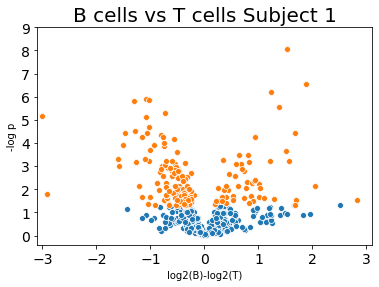

In [15]:
figure = sns.scatterplot(x=comparison_key,y='-log p',data=tstats)
figure2 = sns.scatterplot(x=comparison_key,y='-log p',
                          data=tstats.loc[altered.index])

y = np.random.randint(low=0, high=11, size=100)
plt.yticks(np.arange(0, max(y), 1))

plt.rc('axes',labelsize=20)
plt.xlim(-3.1, 3.1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("B cells vs T cells Subject 1", fontsize=20)


#plt.savefig('data/fig_1b.png', bbox_inches='tight', dpi=300)

This shows the differentially expressed proteins. Recall that this dataset is restricted to those expressed in at least three of each cell type.

The next step is to identify those proteins by name. Here we get the protein names from the fasta file, which remain the same regardless of which software the data was quantified using.


*Note that this function doesn't really have a place in the new set up yet.*

In [16]:
def load_fasta(file="data/uniprot-filtered-proteome_3AUP000005640_reviewed_human.fasta"):
    
    #file is formated:
    #>sp|Q96IY4|CBPB2_HUMAN Carboxypeptidase B2 OS=Homo sapiens OX=9606 GN=CPB2 PE=1 SV=2
    #MKLCS...
    headings = {}
    with open(file) as f:
        for line in f:
            if line.startswith('>'):#header line
                ID = line.split('|')[1]
                name=line.split('|')[2].split('=')[0].strip('OS')
                headings[ID]=name
    headings = pd.Series(list(headings.values()), index=headings.keys())
    
    return headings

In [17]:
protein_names = load_fasta()

In [18]:
protein_names_by_group={}
for ID in prot.data_raw.index:
    if ';' in ID:
        ids = ID.split(';')
        names=''
        for i in ids:
            if i in protein_names.index:
                names=names + protein_names[i] + ';'
        names = names[:-1]
        protein_names_by_group[ID] = names
    else:
        if ID in protein_names.index:
            protein_names_by_group[ID]=protein_names[ID]
protein_names_by_group = pd.Series(list(protein_names_by_group.values()), index=protein_names_by_group.keys())

Here we add the names to the <code>tstats</code> dataframe, which contains the fold changes for each protein. Then we can list the proteins that are altered. Optionally, use <code> head()</code> to display the first few or <code>to_csv</code> to write out to a file. We now split up the proteins heightened in B cells from those heightened in T cells.

In [19]:
tstats['Name']=protein_names_by_group
tstats['GeneID'] = tstats.Name.apply(lambda n: str(n).split('_HUMAN')[0])

altered_proteins = tstats.loc[altered.index].sort_values('log2(B)-log2(T)',
                        ascending=False)[['Name','GeneID','log2(B)-log2(T)','pvalue']]
higher_in_B_cells = altered_proteins.loc[altered_proteins['log2(B)-log2(T)'] >0]
higher_in_T_cells = altered_proteins.loc[altered_proteins['log2(B)-log2(T)'] <0]

#To write out to a file, use:
#altered_proteins.to_csv('data/filename.tsv', sep='\t')

Next we do the same for those only identified in one cell type.

In [20]:
data_in_one_type['Name'] = protein_names_by_group
data_in_one_type['GeneID']=data_in_one_type.Name.apply(lambda n: str(n).split('_HUMAN')[0])

B_cell_only_geneset = data_in_one_type[(data_in_one_type.Type==cell_types[0])]
T_cell_only_geneset= data_in_one_type[(data_in_one_type.Type==cell_types[1])]

### Proteins Higher in B Cells:

In [21]:
higher_in_B_cells

,Name,GeneID,log2(B)-log2(T),pvalue
Protein ID,,,,
Q86Y46,"K2C73_HUMAN Keratin, type II cytoskeletal 73",K2C73,2.824465,2.870075e-02
P01834,IGKC_HUMAN Immunoglobulin kappa constant,IGKC,2.037728,7.591636e-03
P09960,LKHA4_HUMAN Leukotriene A-4 hydrolase,LKHA4,1.882577,2.879600e-07
P10599,THIO_HUMAN Thioredoxin,THIO,1.699129,2.781215e-02
P09525,ANXA4_HUMAN Annexin A4,ANXA4,1.684082,3.593305e-05
P18085,ARF4_HUMAN ADP-ribosylation factor 4,ARF4,1.668645,4.983910e-02
P30040,ERP29_HUMAN Endoplasmic reticulum resident pro...,ERP29,1.567264,5.924181e-04
P29350,PTN6_HUMAN Tyrosine-protein phosphatase non-re...,PTN6,1.533667,8.575830e-09
P0DOY2,IGLC2_HUMAN Immunoglobulin lambda constant 2,IGLC2,1.518162,2.321131e-04


### Proteins Only in B Cells:

In [22]:
B_cell_only_geneset[['Name', 'GeneID']]

,Name,GeneID
Protein ID,,
O60262,GBG7_HUMAN Guanine nucleotide-binding protein ...,GBG7
O60832,DKC1_HUMAN H/ACA ribonucleoprotein complex sub...,DKC1
O75223,GGCT_HUMAN Gamma-glutamylcyclotransferase,GGCT
O75608,LYPA1_HUMAN Acyl-protein thioesterase 1,LYPA1
O75874,IDHC_HUMAN Isocitrate dehydrogenase [NADP] cyt...,IDHC
...,...,...
P01877,IGHA2_HUMAN Immunoglobulin heavy constant alph...,IGHA2
P13498,CY24A_HUMAN Cytochrome b-245 light chain,CY24A
P60033,CD81_HUMAN CD81 antigen,CD81


### Proteins higher or only in B cells by GeneID
<code>B_cell_set</code> is defined here as both the above lists of names, those higher or only in B cells.

In [23]:
B_cell_set = list(higher_in_B_cells.GeneID)+list(B_cell_only_geneset.GeneID)

In [24]:
len(B_cell_set)

131

### Proteins Higher in T Cells:

In [25]:
higher_in_T_cells.sort_values('log2(B)-log2(T)',ascending=True)

,Name,GeneID,log2(B)-log2(T),pvalue
Protein ID,,,,
O14745,NHRF1_HUMAN Na(+)/H(+) exchange regulatory cof...,NHRF1,-4.274482,0.000247
P26447,10A4_HUMAN Protein S100-A4,10A4,-3.003878,0.000007
Q96C19,EFHD2_HUMAN EF-hand domain-containing protein D2,EFHD2,-2.913300,0.016347
Q15149,PLEC_HUMAN Plectin,PLEC,-1.599367,0.000478
Q9Y2Q3,GSTK1_HUMAN Glutathione S-transferase kappa 1,GSTK1,-1.583877,0.001036
...,...,...,...,...
P49368,TCPG_HUMAN T-complex protein 1 subunit gamma,TCPG,-0.247307,0.011586
P07900,HS90A_HUMAN Heat shock protein HSP 90-alpha,HS90A,-0.246409,0.025096
P14618,KPYM_HUMAN Pyruvate kinase PKM,KPYM,-0.244552,0.028731


### Proteins Only in T Cells:

In [26]:
T_cell_only_geneset[['Name', 'GeneID']]

,Name,GeneID
Protein ID,,
O00584,RNT2_HUMAN Ribonuclease T2,RNT2
O15117,FYB1_HUMAN FYN-binding protein 1,FYB1
O43665,RGS10_HUMAN Regulator of G-protein signaling 10,RGS10
O60496,DOK2_HUMAN Docking protein 2,DOK2
O60610,DIAP1_HUMAN Protein diaphanous homolog 1,DIAP1
O60880,H21A_HUMAN SH2 domain-containing protein 1A,H21A
O95571,"ETHE1_HUMAN Persulfide dioxygenase ETHE1, mito...",ETHE1
O95831,"AIFM1_HUMAN Apoptosis-inducing factor 1, mitoc...",AIFM1
O95834,EMAL2_HUMAN Echinoderm microtubule-associated ...,EMAL2


### Proteins higher or only in T cells by GeneID
<code>T_cell_set</code> is defined here as both the above lists of names, those higher or only in T cells.

In [27]:
T_cell_set = list(higher_in_T_cells.GeneID)+list(T_cell_only_geneset.GeneID)

In [28]:
len(T_cell_set)

182

### KEGG pathway enrichment
Here I do a functional pathway enrichment. I use GProfiler to run a KEGG analysis on the differential proteins.
<code>B_cell_set</code> is proteins differentially expressed in B cells
<code>T_cell_set</code> is proteins differentially expressed in T cells

In [29]:
gp = GProfiler(return_dataframe = True)

In [30]:
group1 = gp.profile(organism='hsapiens', query=list(B_cell_set))
b_kegg = group1[group1["source"] == "KEGG"]
b_kegg = b_kegg[['source', 'name', 'p_value', 'description', 'term_size', 'query_size', 'intersection_size']]

In [31]:
group2 = gp.profile(organism='hsapiens', query=list(T_cell_set))
t_kegg = group2[group2["source"] == "KEGG"]
t_kegg = t_kegg[['source', 'name', 'p_value', 'description', 'term_size', 'query_size', 'intersection_size']]